# Load Datasets

In [148]:
import pandas as pd
import numpy as np
import tensorflow as tf

+ X_label IMG

In [149]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [150]:
d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/img.csv')
img_dataset = img_dataset_cache.copy()

In [151]:
img_arr = None

for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)

In [152]:
# check np array is well defined
img_arr.shape

(1205, 150, 150, 3)

+ X_label Facial

In [153]:
pre_facial = pd.read_csv('./dataset/facial.csv')

if 'Unnamed: 0' in pre_facial.columns:
    pre_facial = pre_facial.drop('Unnamed: 0', axis=1)

In [154]:
imsi = pre_facial.copy()

In [155]:
# categorical data to one-hot
fac_input_df = pd.get_dummies(imsi, prefix=['gender', 'dominant_race'])

# Normalization
fac_input_norm = (fac_input_df - fac_input_df.mean()) / fac_input_df.std()

fac_input = np.array(fac_input_norm)

In [156]:
# check np array is well defined
fac_input.shape

(1205, 16)

+ X_label Color

In [157]:
clr_data = pd.read_csv('./dataset/clr.csv')
if 'Unnamed: 0' in clr_data.columns:
    clr_data = clr_data.drop('Unnamed: 0', axis=1)

In [158]:
clr_input = np.array( (clr_data - clr_data.mean())/clr_data.std() )

In [159]:
# check np array is well defined
clr_input.shape

(1205, 3)

+ y_label

In [160]:
y_data = pd.read_csv('./dataset/y_label.csv')

y_out = np.array(y_data)

img_arr = img_arr.astype('float64')

---

# Modeling w/ BP-MLL

Make Model using keras functional api

In [161]:
from keras.layers import Input
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

def multi_input_model(input_shape, classes):
    # IMG Conv Model (not in use)
    real_conv_input = tf.keras.Input(shape=(150,150,3,))
    # conv_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    conv_layer = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(real_conv_input)
    conv_laye2 = tf.keras.layers.Dropout(0.2)(conv_layer)
    conv_laye3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye2)
    conv_laye4 = tf.keras.layers.MaxPooling2D(pool_size=(4,4))(conv_laye3)
    conv_laye5 = tf.keras.layers.Dropout(0.2)(conv_laye4)
    conv_laye6 = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(conv_laye5)
    conv_laye7 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_laye6)
    conv_laye8 = tf.keras.layers.Dropout(0.2)(conv_laye7)
    conv_laye9 = tf.keras.layers.Flatten()(conv_laye8)
    conv_lay10 = tf.keras.layers.Dense(64, activation='relu')(conv_laye9)
    conv_output = tf.keras.layers.Dense(classes, activation='relu')(conv_lay10)
    
    # IMG ResNet Model
    # resnet_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape, input_shape))
    # resnet_input = tf.keras.Input(shape=(input_shape,input_shape,3))
    #resnet_resc = tf.keras.preprocessing.Rescaling(1.0/255)(resnet_input)
    # resnet_output = tf.keras.applications.ResNet50(weights=None, input_shape=(input_shape,input_shape,3), classes=classes)(resnet_input)
    
    # face MLP Model
    real_face_input = tf.keras.layers.Input(shape=(16,))
    face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # face_layer = keras.layers.Dropout(0.2)(face_input)
    face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    face_output = tf.keras.layers.Dense(classes, activation='relu')(face_laye4)#(face_laye5)
    
    # # face MLP Model /w relu
    # real_face_input = tf.keras.layers.Input(shape=(16,))
    # face_input = tf.keras.layers.Dense(256, activation='relu')(real_face_input)
    # #face_layer = keras.layers.Dropout(0.2)(face_input)
    # face_laye2 = tf.keras.layers.Dense(128, activation='relu')(face_input)#(face_layer)
    # #face_laye3 = keras.layers.Dropout(0.2)(face_laye2)
    # face_laye4 = tf.keras.layers.Dense(64, activation='relu')(face_laye2)#(face_laye3)
    # #face_laye5 = keras.layers.Dropout(0.2)(face_laye4)
    # face_output = tf.keras.layers.Dense(classes, activation='softmax')(face_laye4)#(face_laye5)
    
    
    
    # clr MLP Model
    real_clr_input = tf.keras.layers.Input(shape=(3,))
    clr_input = tf.keras.layers.Dense(64, activation='relu')(real_clr_input)
    clr_layer = tf.keras.layers.Dense(32, activation='relu')(clr_input)
    clr_output = tf.keras.layers.Dense(classes, activation='relu')(clr_layer)
    
    
    # concatenate
    concat = tf.keras.layers.Concatenate(axis=-1)([conv_output, face_output, clr_output])
    
    # final model
    final_input = tf.keras.layers.Dense(128, activation='relu')(concat)
    final_layer = tf.keras.layers.Dropout(0.2)(final_input)
    final_laye2 = tf.keras.layers.Dense(128, activation='relu')(final_layer)
    final_laye3 = tf.keras.layers.Dropout(0.2)(final_laye2)
    fianl_laye4 = tf.keras.layers.Dense(64, activation='relu')(final_laye3)
    final_output = tf.keras.layers.Dense(classes, activation='sigmoid')(fianl_laye4)
    
    
    model = tf.keras.models.Model([real_conv_input, real_face_input, real_clr_input], final_output)
    
    return model





In [162]:
NUM_CLASSES = 11
IMG_SIZE = 150

In [163]:
model = multi_input_model(IMG_SIZE, NUM_CLASSES)

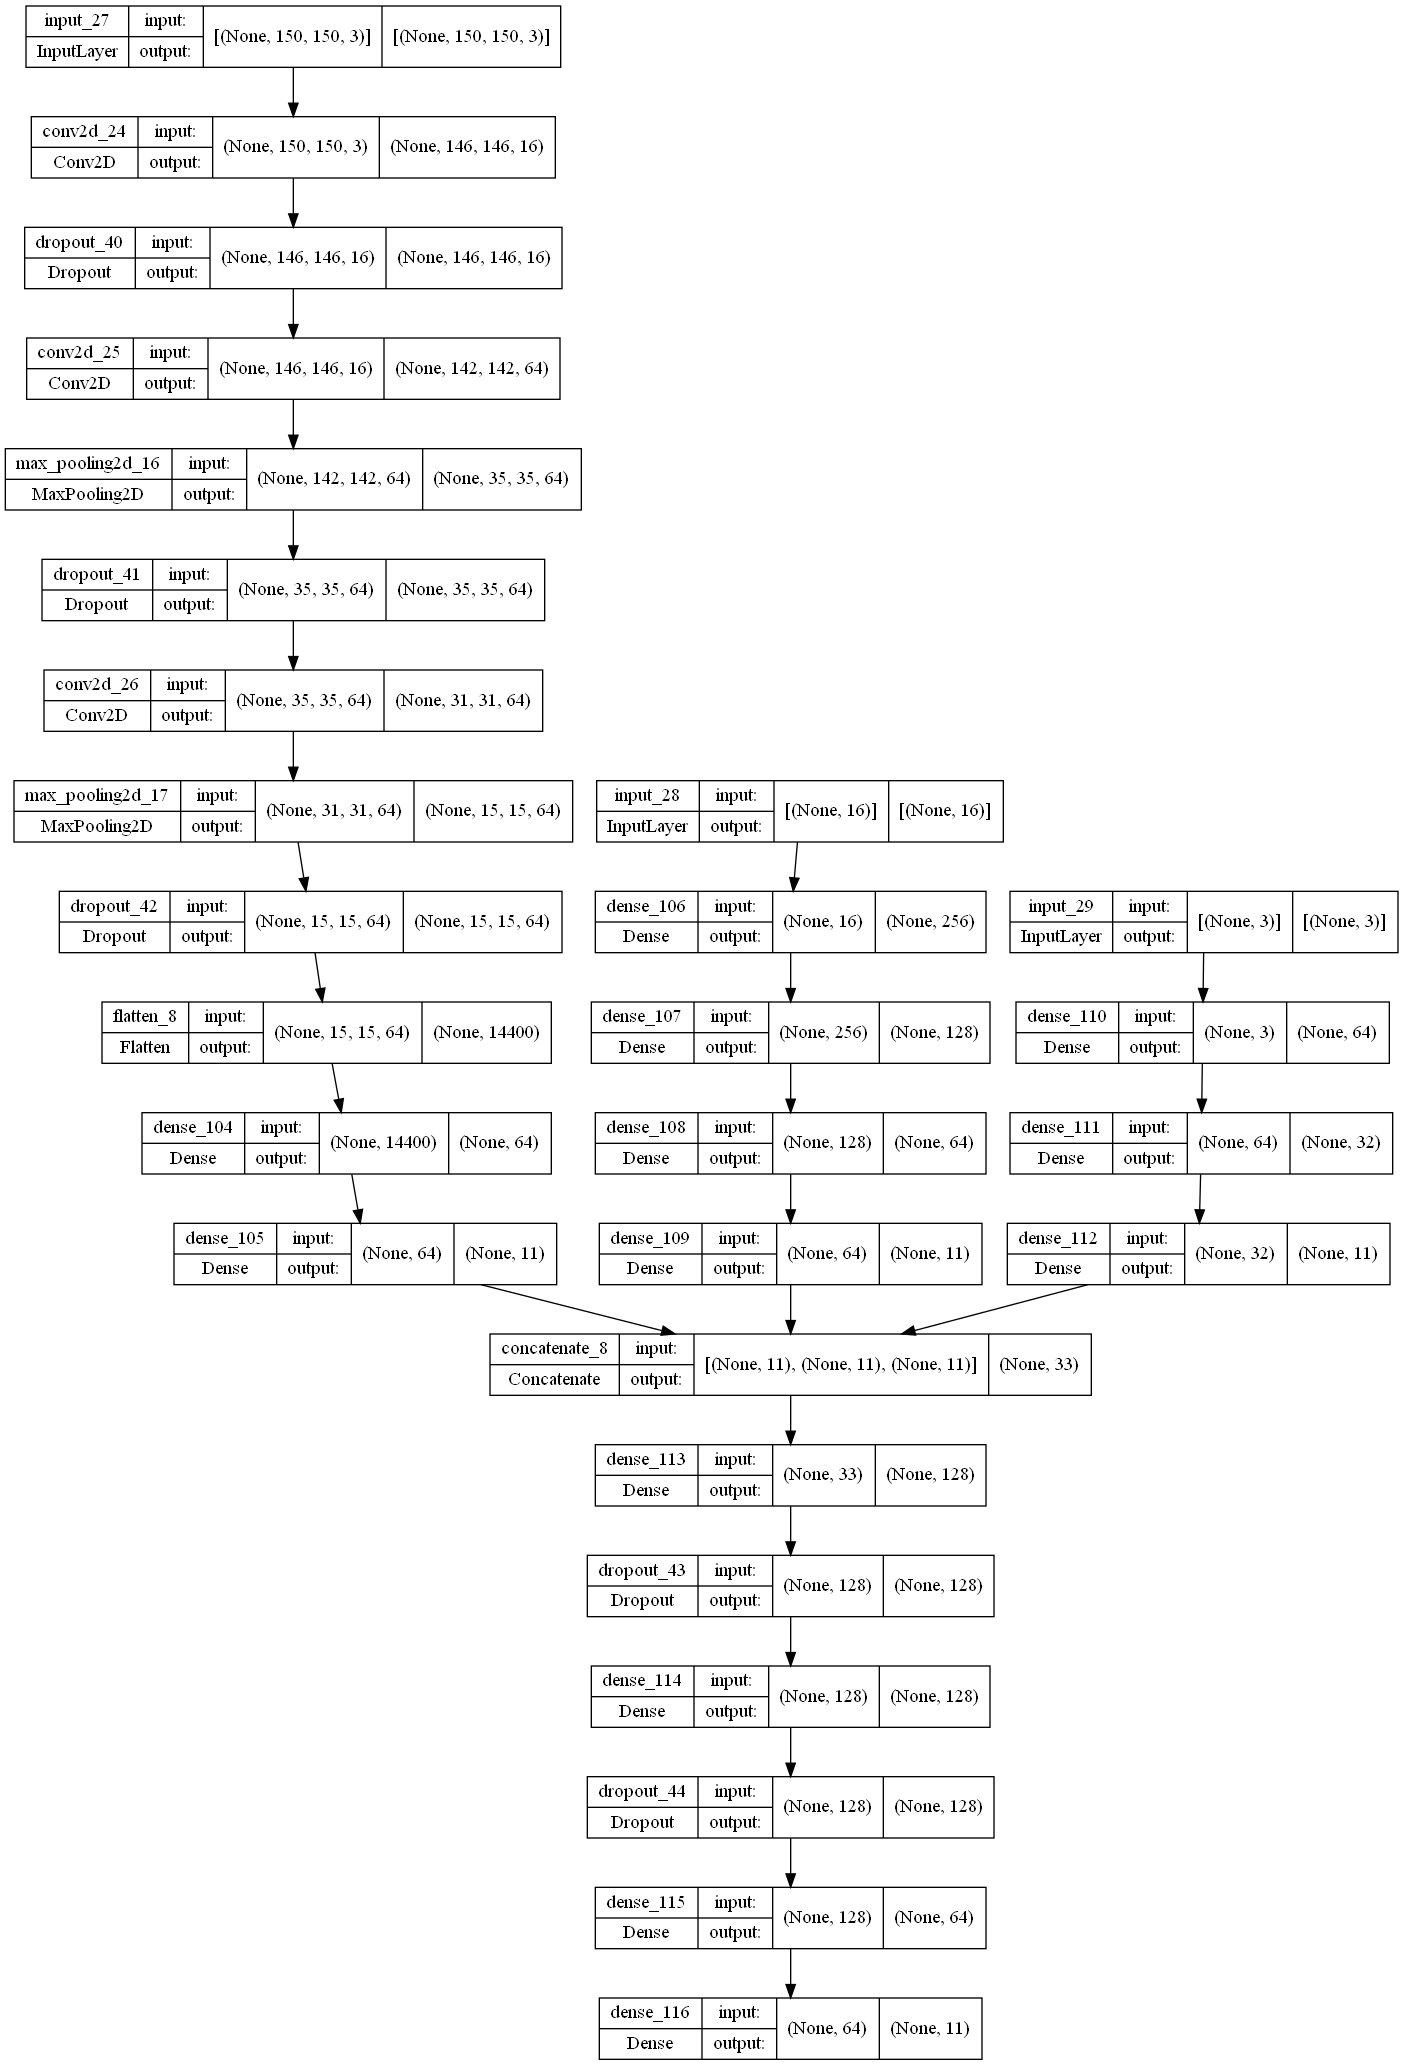

In [164]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [165]:
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.\n",
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

In [166]:
from keras import backend as K
import tensorflow as tf
 
# Compatible with tensorflow backend
 
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                        - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [167]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [168]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = bp_mll_loss,
              optimizer= 'adagrad',
              metrics=['accuracy']

              )

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [169]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=123)
fac_input_s = sklearn.utils.shuffle(fac_input, random_state=123)
clr_input_s = sklearn.utils.shuffle(clr_input, random_state=123)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)

weigh = np.array([1/42, 1/89, 1/112, 1/370, 1/135, 1/250, 1/47, 1/347, 1/51, 1/230, 1/50])
weigh = weigh * 1205 / 11
cw = {0:weigh[0], 1:weigh[1], 2:weigh[2], 3:weigh[3], 4:weigh[4], 5:weigh[5], 6:weigh[6], 7:weigh[7], 8:weigh[8], 9:weigh[9], 10:weigh[10]}

In [170]:
with tf.device("/device:GPU:0"):
  history = model.fit(
  x=[img_arr_s,fac_input_s, clr_input_s],
  y=y_out_s,
  validation_split=0.2,
  epochs=40,
  callbacks=[lr_scheduler],
  class_weight = cw,
  batch_size=32
)

Epoch 1/40
31/31 [==============================] - 3s 47ms/step - loss: 0.7015 - accuracy: 0.0799 - val_loss: 1.0000 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 2/40
31/31 [==============================] - 1s 43ms/step - loss: 0.6998 - accuracy: 0.0913 - val_loss: 0.9991 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 3/40
31/31 [==============================] - 1s 41ms/step - loss: 0.6994 - accuracy: 0.0871 - val_loss: 0.9980 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 4/40
31/31 [==============================] - 1s 40ms/step - loss: 0.6976 - accuracy: 0.0913 - val_loss: 0.9968 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 5/40
31/31 [==============================] - 1s 43ms/step - loss: 0.6964 - accuracy: 0.0871 - val_loss: 0.9954 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 6/40
31/31 [==============================] - 1s 42ms/step - loss: 0.6951 - accuracy: 0.0923 - val_loss: 0.9940 - val_accuracy: 0.0705 - lr: 0.0010
Epoch 7/40
31/31 [==============================] - 1s 41ms/step - loss: 0.6

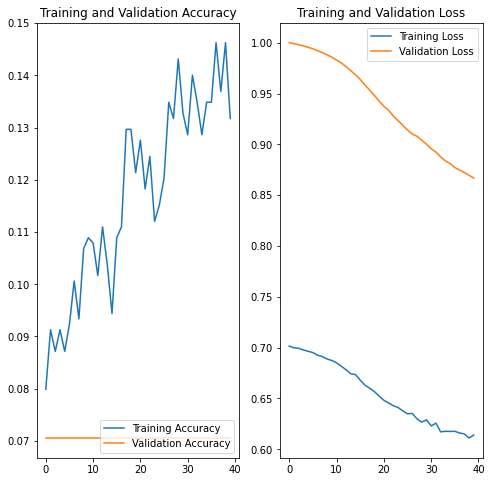

In [172]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [176]:
model.predict([img_arr_s[40:43],fac_input_s[40:43], clr_input_s[40:43]])

array([[0.19888824, 0.28094384, 0.43086267, 0.90421295, 0.54102844,
        0.589909  , 0.10652125, 0.7989961 , 0.19525233, 0.91351944,
        0.24494892],
       [0.13190672, 0.21893604, 0.4155232 , 0.9529426 , 0.54794526,
        0.60195625, 0.05864847, 0.863472  , 0.13185701, 0.9591486 ,
        0.1809564 ],
       [0.12830593, 0.21532157, 0.4125615 , 0.9566388 , 0.5543716 ,
        0.6122555 , 0.05332544, 0.86891305, 0.1275347 , 0.96242005,
        0.1751138 ]], dtype=float32)

In [177]:
y_out[40:43]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [178]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  42
Electronic :  89
Folk, World, & Country :  112
Funk&Soul :  370
Hip Hop :  135
Jazz :  250
Latin :  47
Pop :  347
Reggae :  51
Rock :  230
Stage & Screen :  50
